In [3]:
import numpy as np
import pandas as pd
import os 
import pickle
import sys
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import warnings

torch.set_printoptions(profile="full")
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")

In [4]:
from src.attn import FixedPositionalEncoding, LearnablePositionalEncoding, TemporalEmbedding, MultiheadAttention, Decoder
from src.loss import ContrastiveLoss, FocalLoss

In [5]:
from datetime import datetime

In [6]:
seed = 777
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [7]:
path = '/data/notebook/shared/MIMIC-IV'

In [8]:
with open(os.path.join(path, 'dict_types_nomedi_mimic_240408_clinic_3_years.pkl'), 'rb') as f:
    dtype_dict = pickle.load(f)
f.close()

with open(os.path.join('./data', 'preprocessed_nomedi_240423_clinic_3_years.pkl'), 'rb') as f:
    data_dict_d = pickle.load(f)
f.close()

In [9]:
remain_year_clinical = pd.read_csv(os.path.join(path, "240408_remain_year_clinical_diag_seq_4.csv"))
del remain_year_clinical['clinical_label']

In [10]:
len(dtype_dict)

12702

In [11]:
labels = []
code_labels = []
length_list = []
clinical_labels = []
code_length_list = []
for sample_id, visits in tqdm(data_dict_d.items()):
    # 레이블 추가
    label = visits['label']
    code_label = visits['code_label']
    clinical_label = visits['clinical_label']
    labels.append(label)
    code_labels.append(code_label)
    clinical_labels.append(clinical_labels)

100%|██████████| 8037/8037 [00:00<00:00, 596683.27it/s]


In [12]:
train_indices, test_indices, train_y, test_y = train_test_split(list(data_dict_d.keys()), labels, test_size=0.1, random_state=777, stratify=labels)
train_indices, valid_indices, valid_y, valid_y = train_test_split(train_indices, train_y, test_size=(len(test_indices)/len(train_indices)), random_state=777, stratify=train_y) 

In [13]:
train_data = {}
valid_data = {}
test_data = {}
for sample in tqdm(train_indices):
    train_data[sample] = data_dict_d[sample]

for sample in tqdm(valid_indices):
    valid_data[sample] = data_dict_d[sample]

for sample in tqdm(test_indices):
    test_data[sample] = data_dict_d[sample]

100%|██████████| 804/804 [00:00<00:00, 483195.36it/s]


In [14]:
train_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(train_indices)].reset_index(drop=True)
valid_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(valid_indices)].reset_index(drop=True)
test_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(test_indices)].reset_index(drop=True)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, clinical_df, scaler, mode='train'):       
        self.keys = list(data.keys())  # 딕셔너리의 키 목록 저장
        self.data = data  # 딕셔너리에서 데이터만 추출하여 저장
        self.scaler = scaler
        if mode == 'train':
            scaled_data = self.scaler.fit_transform(clinical_df.iloc[:, 2:])
            scaled_clinical_df = pd.DataFrame(scaled_data, columns = clinical_df.iloc[:, 2:].columns)
            self.scaled_clinical_df = pd.concat([clinical_df.iloc[:, :2], scaled_clinical_df], axis=1)
        else:
            scaled_data = self.scaler.transform(clinical_df.iloc[:, 2:])
            scaled_clinical_df = pd.DataFrame(scaled_data, columns = clinical_df.iloc[:, 2:].columns)
            self.scaled_clinical_df = pd.concat([clinical_df.iloc[:, :2], scaled_clinical_df], axis=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # x는 현재 방문까지의 모든 방문 데이터, y는 다음 방문 데이터
        padding_temp = torch.zeros((1, len(self.data[self.keys[idx]]['code_index'][0])), dtype=torch.long)
        
        origin_visit = torch.tensor(self.data[self.keys[idx]]['code_index'], dtype=torch.long)
        origin_mask = torch.tensor(self.data[self.keys[idx]]['seq_mask'], dtype=torch.long)
        origin_mask_final = torch.tensor(self.data[self.keys[idx]]['seq_mask_final'], dtype=torch.long)
        origin_mask_code = torch.tensor(self.data[self.keys[idx]]['seq_mask_code'], dtype=torch.long)
        
        next_visit = torch.cat((origin_visit[1:], padding_temp), dim=0)
        next_mask =torch.cat((origin_mask[1:], torch.tensor([0], dtype=torch.long)), dim=0)
        next_mask_code = torch.cat((origin_mask_code[1:], padding_temp), dim=0)
        
        clinical_data = self.scaled_clinical_df.loc[self.scaled_clinical_df['subject_id'] == self.keys[idx], self.scaled_clinical_df.columns[2:]].values
        clinical_data = torch.tensor(clinical_data, dtype=torch.float)
        visit_index = torch.tensor(self.data[self.keys[idx]]['year_onehot'], dtype=torch.long)
        last_visit_index = torch.tensor(self.data[self.keys[idx]]['last_year_onehot'], dtype=torch.float)
        time_feature = torch.tensor(self.data[self.keys[idx]]['time_feature'], dtype=torch.long)
        label_per_sample = self.data[self.keys[idx]]['label']
        key_per_sample = self.keys[idx]  # 해당 샘플의 키
        # 키 값도 함께 반환
        return {'sample_id': key_per_sample, 'origin_visit': origin_visit, 'next_visit': next_visit,\
                'origin_mask': origin_mask, 'origin_mask_final': origin_mask_final, 'next_mask': next_mask, \
                'origin_mask_code': origin_mask_code, 'next_mask_code': next_mask_code, 'time_feature': time_feature, \
                'clinical_data': clinical_data, 'visit_index': visit_index, 'last_visit_index': last_visit_index, \
                'label': label_per_sample}

In [16]:
scaler = StandardScaler()
train_dataset = CustomDataset(train_data, train_clinical, scaler, mode='train')
valid_dataset = CustomDataset(valid_data, valid_clinical, scaler, mode='valid')
test_dataset = CustomDataset(test_data, test_clinical, scaler, mode='test')

In [17]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [18]:
class CustomTransformerModel(nn.Module):
    def __init__(self, code_size, ninp, nhead, nhid, nlayers, dropout=0.5, device='cuda:0', pe='fixed'):
        super(CustomTransformerModel, self).__init__()
        self.ninp = ninp  # 축소된 차원 및 Transformer 입력 차원
        self.device = device
        # 차원 축소를 위한 선형 레이어
        self.pre_embedding = nn.Embedding(code_size, self.ninp)
        self.pe = pe
        if self.pe == 'fixed':
            self.pos_encoder = FixedPositionalEncoding(ninp, dropout)
        elif self.pe == 'time_feature':
            self.pos_encoder = TemporalEmbedding(ninp, embed_type='embed', dropout=dropout)
        else:
            self.pos_encoder = LearnablePositionalEncoding(ninp, dropout)
            
        self.transformer_decoder = Decoder(ninp, nhead, nhid, nlayers, dropout)
        self.decoder = nn.Linear(ninp, ninp, bias=False)  # 최종 출력 차원을 설정 (여기서는 ninp로 설정)
        self.classification_layer = nn.Linear(ninp*2, 2)
        self.clinical_transform = nn.Linear(18, ninp) 
        self.cross_attn = MultiheadAttention(ninp, nhead, dropout=0.3)
        self.init_weights()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.pre_embedding.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.xavier_uniform_(self.classification_layer.weight)
    
    def forward(self, batch_data):
        # 차원 축소
        origin_visit = batch_data['origin_visit'].to(self.device)
        next_visit = batch_data['next_visit'].to(self.device)
        clinical_tensor = batch_data['clinical_data'].to(self.device)
        mask_code = batch_data['origin_mask_code'].unsqueeze(3).to(self.device)
        next_mask_code = batch_data['next_mask_code'].unsqueeze(3).to(self.device)
        mask_final = batch_data['origin_mask_final'].unsqueeze(2).to(self.device)
        mask_final_year = batch_data['last_visit_index'].to(self.device)
                
        origin_visit_emb = (self.pre_embedding(origin_visit) * mask_code).sum(dim=2)
        next_visit_emb = (self.pre_embedding(next_visit) * next_mask_code).sum(dim=2)
        # 위치 인코딩 및 Transformer 디코더 적용
        if self.pe == 'time_feature':
            time_feature = batch_data['time_feature'].to(self.device)
            src = self.pos_encoder(origin_visit_emb, time_feature)
        else:
            src = self.pos_encoder(origin_visit_emb)
        
        seq_len = src.shape[1]
        src_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.uint8, device=self.device), diagonal=1)
        output = self.transformer_decoder(src, attention_mask=src_mask)
        output = self.decoder(output)
        
        output_batch, output_visit_num, output_dim = output.size()
        next_visit_output_batch, next_visit_output_num, next_visit_output_dim = next_visit_emb.size()
        
        # print(output[:, :torch.,:])
        temp_output = output.reshape(-1, output_dim)
        temp_next_visit = next_visit_emb.reshape(-1, next_visit_output_dim)
        final_visit = (output * mask_final).sum(dim=1)
        year_emb = torch.bmm(output.transpose(1,2), mask_final_year).transpose(1,2)[:,:2,:]
        
        transformed_clinical = self.clinical_transform(clinical_tensor)
        mixed_output, mixed_cross_attn = self.cross_attn(year_emb, transformed_clinical, transformed_clinical)
        mixed_output = mixed_output[:,-1,:]
        mixed_final_emb = torch.cat((final_visit, mixed_output), dim=-1)
        classification_result = self.classification_layer(mixed_final_emb)    
        return temp_output, temp_next_visit, classification_result, final_visit

In [19]:
lr = 0.001
ninp = 64
nhid = 256
nlayer = 5
gamma = 0.5
cos_lambda = 1
classi_lambda = 1

model_name = 'no_center_total_label'
pe = 'time_feature'

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = CustomTransformerModel(len(dtype_dict), ninp=ninp, nhead=8, nhid=nhid, nlayers=nlayer, dropout=0.1, device=device, pe=pe).to(device)
# model_2 = CustomTransformerModel(len(dtype_dict), ninp=ninp, nhead=8, nhid=nhid, nlayers=nlayer, dropout=0.6, device=device, pe='fixed').to(device)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr, weight_decay=1e-5)

# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss(2, gamma=gamma)
# cosine_loss = CosineSimilarityLoss()
cosine_embedding_loss = nn.CosineEmbeddingLoss()
# const_loss = ContrastiveLoss(temperature=0.05)

In [19]:
# 얼리 스타핑 설정
num_epochs = 200
patience = 30
best_loss = float("inf")
counter = 0
epoch_temp = 0

best_f1 = 0.0
best_combined_score = 0.0
best_epoch = 0

view_total_loss = []
view_cos_loss = []
view_classi_loss = []


for epoch in tqdm(range(num_epochs)):
    model_1.train()

    total_train_loss = 0
    total_cos_loss = 0
    total_classi_loss = 0
    total_const_loss = 0
    # key_per_sample, origin_visit, origin_mask, origin_mask_code, origin_mask_final, next_visit, next_mask, next_mask_code, next_mask_final, label_per_sample
    for batch_data in train_loader:
        tr_labels = batch_data['label'].to(device)
        optimizer.zero_grad()
        output_1, next_visit_output_1, final_visit_classification_1, final_visit_1 = model_1(batch_data)
        y = torch.ones(output_1.size(0), dtype=torch.float, device=device)
        y = y.to(device)   
        cosine_loss_mean_1 = cosine_embedding_loss(output_1, next_visit_output_1, y)
        classification_loss_1 = criterion(final_visit_classification_1.squeeze(), tr_labels.long())
        loss = (cos_lambda * cosine_loss_mean_1) + (classi_lambda * classification_loss_1)

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_cos_loss += (cosine_loss_mean_1.item())
        total_classi_loss += (classification_loss_1.item())
        # total_const_loss += train_const_loss.item()

        view_total_loss.append(total_train_loss)
        view_cos_loss.append(total_cos_loss)
        view_classi_loss.append(total_classi_loss)

    # 평균 손실 계산
    avg_train_loss = total_train_loss / len(train_loader)
    avg_cos_loss = total_cos_loss / len(train_loader)
    avg_classi_loss = total_classi_loss / len(train_loader)

    print("Epoch:", epoch+1, ", Total loss:", round(avg_train_loss, 4), ", cos_loss : ",\
          round(avg_cos_loss, 4), ", classification_loss :",round(avg_classi_loss, 4))

    model_1.eval()
    total_val_loss = 0
    total_val_cos_loss = 0
    total_val_classi_loss = 0
    total_val_const_loss = 0

    val_labels_list = []
    val_predictions_list = []
    val_probabilities_list = []


    with torch.no_grad():
        for batch_data in valid_loader:
            val_labels = batch_data['label'].to(device)
            val_output_1, val_next_visit_output_1, val_final_visit_classification_1, val_final_visit_1 = model_1(batch_data)
            
            y_val = torch.ones(val_output_1.size(0), dtype=torch.float, device=device) 
            val_cosine_loss_mean_1 = cosine_embedding_loss(val_output_1, val_next_visit_output_1, y_val)
            
            classification_loss_val_1 = criterion(val_final_visit_classification_1.squeeze(), val_labels.long())            

            val_loss = (cos_lambda * val_cosine_loss_mean_1) + (classi_lambda * classification_loss_val_1) 
            
            total_val_loss += val_loss.item()
            total_val_cos_loss += (val_cosine_loss_mean_1.item())
            total_val_classi_loss += (classification_loss_val_1.item())
            # total_val_const_loss += val_const_loss.item()

            val_probs = F.softmax(val_final_visit_classification_1)
            val_predictions = torch.max(val_probs, 1)[1].view((len(val_labels),))

            val_labels_list.extend(val_labels.view(-1).cpu().numpy())
            val_predictions_list.extend(val_predictions.cpu().numpy())
            
            ########
            val_probabilities_list.extend(val_probs[:,1].cpu().numpy())
            ######## 
            
            
        avg_val_loss = total_val_loss / len(valid_loader)
        avg_val_cos_loss = total_val_cos_loss / len(valid_loader)
        avg_val_classi_loss = total_val_classi_loss / len(valid_loader)

    # 성능 지표 계산
    accuracy = accuracy_score(val_labels_list, val_predictions_list)
    auc = roc_auc_score(val_labels_list, val_probabilities_list)
    f1 = f1_score(val_labels_list, val_predictions_list)
    precision = precision_score(val_labels_list,val_predictions_list)
    recall = recall_score(val_labels_list, val_predictions_list)

    print("Epoch:", epoch+1, ", valid loss:", round(avg_val_loss, 4), ", cos_loss : ",\
          round(avg_val_cos_loss, 4), ", classification_loss :",round(avg_val_classi_loss, 4))
    print("Accuracy:", round(accuracy,4), ", AUC: ", round(auc,4), ", F1: ", round(f1,4), ", Precision: ", round(precision,4), ", recall: ", round(recall,4))

    current_auc = roc_auc_score(val_labels_list, val_probabilities_list)
    current_f1 = f1_score(val_labels_list, val_predictions_list)
    current_combined_score = current_f1

    # 모델 저장 경로 설정
    model_save_path = f'results'
    date_dir = datetime.today().strftime("%Y%m%d")
    model_time =  datetime.today().strftime("%H%M%S")
    # 학습률과 분류 가중치를 파일명에 포함시키기 위한 문자열 포맷
    model_filename_format = f'model_lr{lr}_classi{classi_lambda}_dim{ninp}_hid{nhid}_layer{nlayer}_epoch{{epoch}}_{{model}}_{{pe}}_{{gamma}}_{model_time}.pth'

    # 모델 저장 폴더가 없으면 생성
    os.makedirs(os.path.join(model_save_path, date_dir), exist_ok=True)

    if current_combined_score > best_combined_score:
        best_combined_score = current_combined_score
        best_epoch = epoch
        counter = 0
        # 모델 저장 경로와 파일명을 결합하여 전체 파일 경로 생성
        model_1_save_path = os.path.join(model_save_path, date_dir, model_filename_format.format(epoch=best_epoch, model=model_name, pe=pe, gamma=gamma))
        # 모델 저장
        torch.save(model_1.state_dict(), f'{model_1_save_path}')
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered at epoch {}".format(best_epoch))
        print(f"Best Combined Score (AUC): {best_combined_score:.4f}")
        break

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 , Total loss: 1.3239 , cos_loss :  0.9689 , classification_loss : 0.355


  0%|          | 1/200 [00:03<12:56,  3.90s/it]

Epoch: 1 , valid loss: 1.1533 , cos_loss :  0.9358 , classification_loss : 0.2175
Accuracy: 0.9129 , AUC:  0.5192 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 2 , Total loss: 1.1438 , cos_loss :  0.9278 , classification_loss : 0.216


  1%|          | 2/200 [00:07<12:57,  3.93s/it]

Epoch: 2 , valid loss: 1.1259 , cos_loss :  0.9183 , classification_loss : 0.2077
Accuracy: 0.9129 , AUC:  0.5369 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 3 , Total loss: 1.1274 , cos_loss :  0.9188 , classification_loss : 0.2086


  2%|▏         | 3/200 [00:11<11:58,  3.65s/it]

Epoch: 3 , valid loss: 1.1178 , cos_loss :  0.9145 , classification_loss : 0.2034
Accuracy: 0.9129 , AUC:  0.564 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 4 , Total loss: 1.1243 , cos_loss :  0.9167 , classification_loss : 0.2076


  2%|▏         | 4/200 [00:14<11:28,  3.52s/it]

Epoch: 4 , valid loss: 1.114 , cos_loss :  0.9132 , classification_loss : 0.2009
Accuracy: 0.9129 , AUC:  0.5858 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 5 , Total loss: 1.1236 , cos_loss :  0.9155 , classification_loss : 0.208


  2%|▎         | 5/200 [00:17<11:19,  3.49s/it]

Epoch: 5 , valid loss: 1.1139 , cos_loss :  0.9126 , classification_loss : 0.2013
Accuracy: 0.9129 , AUC:  0.5835 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 6 , Total loss: 1.1194 , cos_loss :  0.9152 , classification_loss : 0.2042


  3%|▎         | 6/200 [00:21<11:05,  3.43s/it]

Epoch: 6 , valid loss: 1.1126 , cos_loss :  0.9122 , classification_loss : 0.2004
Accuracy: 0.9129 , AUC:  0.5811 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 7 , Total loss: 1.1192 , cos_loss :  0.9147 , classification_loss : 0.2045


  4%|▎         | 7/200 [00:24<11:04,  3.45s/it]

Epoch: 7 , valid loss: 1.1122 , cos_loss :  0.912 , classification_loss : 0.2002
Accuracy: 0.9129 , AUC:  0.5834 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 8 , Total loss: 1.1179 , cos_loss :  0.9147 , classification_loss : 0.2031


  4%|▍         | 8/200 [00:28<10:55,  3.41s/it]

Epoch: 8 , valid loss: 1.1105 , cos_loss :  0.9118 , classification_loss : 0.1987
Accuracy: 0.9129 , AUC:  0.6003 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 9 , Total loss: 1.1159 , cos_loss :  0.9146 , classification_loss : 0.2013


  4%|▍         | 9/200 [00:31<10:50,  3.41s/it]

Epoch: 9 , valid loss: 1.1083 , cos_loss :  0.9117 , classification_loss : 0.1966
Accuracy: 0.9129 , AUC:  0.6162 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 10 , Total loss: 1.1127 , cos_loss :  0.9145 , classification_loss : 0.1982


  5%|▌         | 10/200 [00:34<10:41,  3.38s/it]

Epoch: 10 , valid loss: 1.1005 , cos_loss :  0.9117 , classification_loss : 0.1888
Accuracy: 0.9129 , AUC:  0.6748 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 11 , Total loss: 1.0906 , cos_loss :  0.9153 , classification_loss : 0.1753


  6%|▌         | 11/200 [00:38<10:34,  3.36s/it]

Epoch: 11 , valid loss: 1.0679 , cos_loss :  0.9137 , classification_loss : 0.1542
Accuracy: 0.9415 , AUC:  0.7104 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 12 , Total loss: 1.063 , cos_loss :  0.9174 , classification_loss : 0.1456


  6%|▌         | 12/200 [00:41<10:33,  3.37s/it]

Epoch: 12 , valid loss: 1.075 , cos_loss :  0.9162 , classification_loss : 0.1587
Accuracy: 0.9415 , AUC:  0.7275 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 13 , Total loss: 1.0628 , cos_loss :  0.9168 , classification_loss : 0.146


  6%|▋         | 13/200 [00:44<10:27,  3.36s/it]

Epoch: 13 , valid loss: 1.064 , cos_loss :  0.9134 , classification_loss : 0.1506
Accuracy: 0.9415 , AUC:  0.7319 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 14 , Total loss: 1.056 , cos_loss :  0.916 , classification_loss : 0.14


  7%|▋         | 14/200 [00:48<10:28,  3.38s/it]

Epoch: 14 , valid loss: 1.0642 , cos_loss :  0.9141 , classification_loss : 0.1502
Accuracy: 0.9415 , AUC:  0.7361 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 15 , Total loss: 1.0564 , cos_loss :  0.9162 , classification_loss : 0.1402


  8%|▊         | 15/200 [00:51<10:21,  3.36s/it]

Epoch: 15 , valid loss: 1.062 , cos_loss :  0.9141 , classification_loss : 0.1479
Accuracy: 0.9415 , AUC:  0.7534 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 16 , Total loss: 1.0585 , cos_loss :  0.9159 , classification_loss : 0.1426


  8%|▊         | 16/200 [00:54<10:20,  3.37s/it]

Epoch: 16 , valid loss: 1.0627 , cos_loss :  0.9136 , classification_loss : 0.1491
Accuracy: 0.9428 , AUC:  0.7501 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 17 , Total loss: 1.0504 , cos_loss :  0.916 , classification_loss : 0.1344


  8%|▊         | 17/200 [00:58<10:13,  3.35s/it]

Epoch: 17 , valid loss: 1.0555 , cos_loss :  0.9138 , classification_loss : 0.1417
Accuracy: 0.9415 , AUC:  0.7678 , F1:  0.4946 , Precision:  1.0 , recall:  0.3286
Epoch: 18 , Total loss: 1.0479 , cos_loss :  0.9161 , classification_loss : 0.1318


  9%|▉         | 18/200 [01:01<10:12,  3.37s/it]

Epoch: 18 , valid loss: 1.0562 , cos_loss :  0.9141 , classification_loss : 0.1422
Accuracy: 0.9428 , AUC:  0.7718 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 19 , Total loss: 1.0484 , cos_loss :  0.9162 , classification_loss : 0.1322


 10%|▉         | 19/200 [01:04<10:07,  3.36s/it]

Epoch: 19 , valid loss: 1.0552 , cos_loss :  0.9139 , classification_loss : 0.1413
Accuracy: 0.9428 , AUC:  0.7717 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 20 , Total loss: 1.0429 , cos_loss :  0.9161 , classification_loss : 0.1269


 10%|█         | 20/200 [01:09<10:46,  3.59s/it]

Epoch: 20 , valid loss: 1.055 , cos_loss :  0.9146 , classification_loss : 0.1404
Accuracy: 0.9428 , AUC:  0.7749 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 21 , Total loss: 1.039 , cos_loss :  0.9163 , classification_loss : 0.1227


 10%|█         | 21/200 [01:13<10:59,  3.69s/it]

Epoch: 21 , valid loss: 1.0623 , cos_loss :  0.9143 , classification_loss : 0.148
Accuracy: 0.9428 , AUC:  0.7621 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 22 , Total loss: 1.049 , cos_loss :  0.9161 , classification_loss : 0.133


 11%|█         | 22/200 [01:16<10:48,  3.64s/it]

Epoch: 22 , valid loss: 1.0549 , cos_loss :  0.9146 , classification_loss : 0.1404
Accuracy: 0.9428 , AUC:  0.7934 , F1:  0.5106 , Precision:  1.0 , recall:  0.3429
Epoch: 23 , Total loss: 1.0384 , cos_loss :  0.9163 , classification_loss : 0.1221


 12%|█▏        | 23/200 [01:20<10:44,  3.64s/it]

Epoch: 23 , valid loss: 1.0531 , cos_loss :  0.914 , classification_loss : 0.1391
Accuracy: 0.9453 , AUC:  0.7705 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 24 , Total loss: 1.042 , cos_loss :  0.9159 , classification_loss : 0.1261


 12%|█▏        | 24/200 [01:23<10:33,  3.60s/it]

Epoch: 24 , valid loss: 1.0557 , cos_loss :  0.9146 , classification_loss : 0.1411
Accuracy: 0.9453 , AUC:  0.7714 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 25 , Total loss: 1.0392 , cos_loss :  0.9162 , classification_loss : 0.123


 12%|█▎        | 25/200 [01:27<10:28,  3.59s/it]

Epoch: 25 , valid loss: 1.0537 , cos_loss :  0.9145 , classification_loss : 0.1392
Accuracy: 0.944 , AUC:  0.7779 , F1:  0.5263 , Precision:  1.0 , recall:  0.3571
Epoch: 26 , Total loss: 1.0382 , cos_loss :  0.9159 , classification_loss : 0.1222


 13%|█▎        | 26/200 [01:30<10:20,  3.56s/it]

Epoch: 26 , valid loss: 1.0527 , cos_loss :  0.914 , classification_loss : 0.1387
Accuracy: 0.9453 , AUC:  0.7798 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 27 , Total loss: 1.035 , cos_loss :  0.9158 , classification_loss : 0.1192


 14%|█▎        | 27/200 [01:34<10:13,  3.55s/it]

Epoch: 27 , valid loss: 1.0559 , cos_loss :  0.9144 , classification_loss : 0.1415
Accuracy: 0.944 , AUC:  0.7771 , F1:  0.5263 , Precision:  1.0 , recall:  0.3571
Epoch: 28 , Total loss: 1.0343 , cos_loss :  0.916 , classification_loss : 0.1183


 14%|█▍        | 28/200 [01:37<10:03,  3.51s/it]

Epoch: 28 , valid loss: 1.0552 , cos_loss :  0.9146 , classification_loss : 0.1406
Accuracy: 0.9465 , AUC:  0.7754 , F1:  0.5567 , Precision:  1.0 , recall:  0.3857
Epoch: 29 , Total loss: 1.0347 , cos_loss :  0.916 , classification_loss : 0.1187


 14%|█▍        | 29/200 [01:41<10:09,  3.57s/it]

Epoch: 29 , valid loss: 1.0662 , cos_loss :  0.9138 , classification_loss : 0.1524
Accuracy: 0.9465 , AUC:  0.7886 , F1:  0.5825 , Precision:  0.9091 , recall:  0.4286
Epoch: 30 , Total loss: 1.0399 , cos_loss :  0.916 , classification_loss : 0.124


 15%|█▌        | 30/200 [01:45<10:12,  3.60s/it]

Epoch: 30 , valid loss: 1.0551 , cos_loss :  0.9143 , classification_loss : 0.1409
Accuracy: 0.9453 , AUC:  0.7902 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 31 , Total loss: 1.0353 , cos_loss :  0.9157 , classification_loss : 0.1196


 16%|█▌        | 31/200 [01:48<10:04,  3.58s/it]

Epoch: 31 , valid loss: 1.0522 , cos_loss :  0.9139 , classification_loss : 0.1383
Accuracy: 0.9465 , AUC:  0.7823 , F1:  0.5567 , Precision:  1.0 , recall:  0.3857
Epoch: 32 , Total loss: 1.0382 , cos_loss :  0.916 , classification_loss : 0.1222


 16%|█▌        | 32/200 [01:52<10:03,  3.59s/it]

Epoch: 32 , valid loss: 1.0571 , cos_loss :  0.9142 , classification_loss : 0.1429
Accuracy: 0.9478 , AUC:  0.7844 , F1:  0.58 , Precision:  0.9667 , recall:  0.4143
Epoch: 33 , Total loss: 1.0315 , cos_loss :  0.916 , classification_loss : 0.1156


 16%|█▋        | 33/200 [01:55<09:52,  3.55s/it]

Epoch: 33 , valid loss: 1.0543 , cos_loss :  0.9145 , classification_loss : 0.1398
Accuracy: 0.9502 , AUC:  0.7793 , F1:  0.6 , Precision:  1.0 , recall:  0.4286
Epoch: 34 , Total loss: 1.0305 , cos_loss :  0.9159 , classification_loss : 0.1146


 17%|█▋        | 34/200 [01:59<09:45,  3.53s/it]

Epoch: 34 , valid loss: 1.0571 , cos_loss :  0.9142 , classification_loss : 0.1429
Accuracy: 0.9453 , AUC:  0.7751 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 35 , Total loss: 1.0268 , cos_loss :  0.916 , classification_loss : 0.1108


 18%|█▊        | 35/200 [02:03<10:03,  3.66s/it]

Epoch: 35 , valid loss: 1.0608 , cos_loss :  0.9147 , classification_loss : 0.1461
Accuracy: 0.9453 , AUC:  0.7826 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 36 , Total loss: 1.027 , cos_loss :  0.916 , classification_loss : 0.111


 18%|█▊        | 36/200 [02:06<10:04,  3.68s/it]

Epoch: 36 , valid loss: 1.0587 , cos_loss :  0.9143 , classification_loss : 0.1444
Accuracy: 0.949 , AUC:  0.7776 , F1:  0.6019 , Precision:  0.9394 , recall:  0.4429
Epoch: 37 , Total loss: 1.0243 , cos_loss :  0.9162 , classification_loss : 0.1081


 18%|█▊        | 37/200 [02:10<09:56,  3.66s/it]

Epoch: 37 , valid loss: 1.0698 , cos_loss :  0.9152 , classification_loss : 0.1546
Accuracy: 0.9453 , AUC:  0.769 , F1:  0.5417 , Precision:  1.0 , recall:  0.3714
Epoch: 38 , Total loss: 1.0255 , cos_loss :  0.9164 , classification_loss : 0.1091


 19%|█▉        | 38/200 [02:13<09:43,  3.60s/it]

Epoch: 38 , valid loss: 1.0618 , cos_loss :  0.9153 , classification_loss : 0.1465
Accuracy: 0.944 , AUC:  0.774 , F1:  0.5361 , Precision:  0.963 , recall:  0.3714
Epoch: 39 , Total loss: 1.0201 , cos_loss :  0.9173 , classification_loss : 0.1028


 20%|█▉        | 39/200 [02:17<09:37,  3.59s/it]

Epoch: 39 , valid loss: 1.0835 , cos_loss :  0.9165 , classification_loss : 0.167
Accuracy: 0.944 , AUC:  0.7713 , F1:  0.5263 , Precision:  1.0 , recall:  0.3571
Epoch: 40 , Total loss: 1.0169 , cos_loss :  0.9176 , classification_loss : 0.0993


 20%|██        | 40/200 [02:20<09:22,  3.52s/it]

Epoch: 40 , valid loss: 1.0747 , cos_loss :  0.9163 , classification_loss : 0.1584
Accuracy: 0.9428 , AUC:  0.772 , F1:  0.566 , Precision:  0.8333 , recall:  0.4286
Epoch: 41 , Total loss: 1.0014 , cos_loss :  0.9184 , classification_loss : 0.083


 20%|██        | 41/200 [02:24<09:20,  3.53s/it]

Epoch: 41 , valid loss: 1.0988 , cos_loss :  0.9175 , classification_loss : 0.1813
Accuracy: 0.9403 , AUC:  0.7609 , F1:  0.52 , Precision:  0.8667 , recall:  0.3714
Epoch: 42 , Total loss: 0.9917 , cos_loss :  0.9192 , classification_loss : 0.0725


 21%|██        | 42/200 [02:27<09:15,  3.52s/it]

Epoch: 42 , valid loss: 1.0874 , cos_loss :  0.9186 , classification_loss : 0.1688
Accuracy: 0.9403 , AUC:  0.7705 , F1:  0.5294 , Precision:  0.8438 , recall:  0.3857
Epoch: 43 , Total loss: 0.9802 , cos_loss :  0.9201 , classification_loss : 0.06


 22%|██▏       | 43/200 [02:31<09:19,  3.56s/it]

Epoch: 43 , valid loss: 1.1135 , cos_loss :  0.9193 , classification_loss : 0.1942
Accuracy: 0.9254 , AUC:  0.7757 , F1:  0.4915 , Precision:  0.6042 , recall:  0.4143
Epoch: 44 , Total loss: 0.9719 , cos_loss :  0.921 , classification_loss : 0.0509


 22%|██▏       | 44/200 [02:34<09:10,  3.53s/it]

Epoch: 44 , valid loss: 1.1027 , cos_loss :  0.9199 , classification_loss : 0.1828
Accuracy: 0.9341 , AUC:  0.7731 , F1:  0.531 , Precision:  0.6977 , recall:  0.4286
Epoch: 45 , Total loss: 0.9639 , cos_loss :  0.9212 , classification_loss : 0.0427


 22%|██▎       | 45/200 [02:38<09:08,  3.54s/it]

Epoch: 45 , valid loss: 1.1208 , cos_loss :  0.9201 , classification_loss : 0.2008
Accuracy: 0.9341 , AUC:  0.785 , F1:  0.5047 , Precision:  0.7297 , recall:  0.3857
Epoch: 46 , Total loss: 0.9591 , cos_loss :  0.9216 , classification_loss : 0.0376


 23%|██▎       | 46/200 [02:42<09:13,  3.59s/it]

Epoch: 46 , valid loss: 1.1189 , cos_loss :  0.9203 , classification_loss : 0.1986
Accuracy: 0.9403 , AUC:  0.7762 , F1:  0.5472 , Precision:  0.8056 , recall:  0.4143
Epoch: 47 , Total loss: 0.9591 , cos_loss :  0.9218 , classification_loss : 0.0373


 24%|██▎       | 47/200 [02:45<09:13,  3.61s/it]

Epoch: 47 , valid loss: 1.1375 , cos_loss :  0.9205 , classification_loss : 0.217
Accuracy: 0.9266 , AUC:  0.7706 , F1:  0.5124 , Precision:  0.6078 , recall:  0.4429
Epoch: 48 , Total loss: 0.9513 , cos_loss :  0.9216 , classification_loss : 0.0297


 24%|██▍       | 48/200 [02:49<08:59,  3.55s/it]

Epoch: 48 , valid loss: 1.1351 , cos_loss :  0.9202 , classification_loss : 0.2148
Accuracy: 0.9303 , AUC:  0.7776 , F1:  0.5254 , Precision:  0.6458 , recall:  0.4429
Epoch: 49 , Total loss: 0.95 , cos_loss :  0.9219 , classification_loss : 0.0281


 24%|██▍       | 49/200 [02:52<08:46,  3.48s/it]

Epoch: 49 , valid loss: 1.194 , cos_loss :  0.9208 , classification_loss : 0.2731
Accuracy: 0.9204 , AUC:  0.7718 , F1:  0.4754 , Precision:  0.5577 , recall:  0.4143
Epoch: 50 , Total loss: 0.9467 , cos_loss :  0.9216 , classification_loss : 0.0251


 25%|██▌       | 50/200 [02:56<08:56,  3.58s/it]

Epoch: 50 , valid loss: 1.1542 , cos_loss :  0.9203 , classification_loss : 0.2339
Accuracy: 0.9266 , AUC:  0.7884 , F1:  0.4779 , Precision:  0.6279 , recall:  0.3857
Epoch: 51 , Total loss: 0.9414 , cos_loss :  0.9217 , classification_loss : 0.0197


 26%|██▌       | 51/200 [02:59<08:44,  3.52s/it]

Epoch: 51 , valid loss: 1.1398 , cos_loss :  0.9203 , classification_loss : 0.2195
Accuracy: 0.9291 , AUC:  0.794 , F1:  0.5128 , Precision:  0.6383 , recall:  0.4286
Epoch: 52 , Total loss: 0.9398 , cos_loss :  0.9215 , classification_loss : 0.0183


 26%|██▌       | 52/200 [03:03<08:39,  3.51s/it]

Epoch: 52 , valid loss: 1.1569 , cos_loss :  0.9196 , classification_loss : 0.2373
Accuracy: 0.9216 , AUC:  0.7812 , F1:  0.4878 , Precision:  0.566 , recall:  0.4286
Epoch: 53 , Total loss: 0.9441 , cos_loss :  0.921 , classification_loss : 0.023


 26%|██▋       | 53/200 [03:06<08:32,  3.48s/it]

Epoch: 53 , valid loss: 1.1669 , cos_loss :  0.9195 , classification_loss : 0.2474
Accuracy: 0.9254 , AUC:  0.7678 , F1:  0.5 , Precision:  0.6 , recall:  0.4286
Epoch: 54 , Total loss: 0.943 , cos_loss :  0.9207 , classification_loss : 0.0222


 27%|██▋       | 54/200 [03:10<08:27,  3.48s/it]

Epoch: 54 , valid loss: 1.1735 , cos_loss :  0.9198 , classification_loss : 0.2537
Accuracy: 0.9241 , AUC:  0.7758 , F1:  0.4874 , Precision:  0.5918 , recall:  0.4143
Epoch: 55 , Total loss: 0.9395 , cos_loss :  0.9213 , classification_loss : 0.0182


 28%|██▊       | 55/200 [03:13<08:29,  3.52s/it]

Epoch: 55 , valid loss: 1.2272 , cos_loss :  0.9202 , classification_loss : 0.3069
Accuracy: 0.9104 , AUC:  0.7735 , F1:  0.4627 , Precision:  0.4844 , recall:  0.4429
Epoch: 56 , Total loss: 0.9412 , cos_loss :  0.9212 , classification_loss : 0.02


 28%|██▊       | 56/200 [03:17<08:26,  3.52s/it]

Epoch: 56 , valid loss: 1.1671 , cos_loss :  0.9195 , classification_loss : 0.2476
Accuracy: 0.9353 , AUC:  0.7828 , F1:  0.5185 , Precision:  0.7368 , recall:  0.4
Epoch: 57 , Total loss: 0.9463 , cos_loss :  0.921 , classification_loss : 0.0253


 28%|██▊       | 57/200 [03:21<08:29,  3.57s/it]

Epoch: 57 , valid loss: 1.1789 , cos_loss :  0.9199 , classification_loss : 0.259
Accuracy: 0.9328 , AUC:  0.7828 , F1:  0.5 , Precision:  0.7105 , recall:  0.3857
Epoch: 58 , Total loss: 0.9397 , cos_loss :  0.9213 , classification_loss : 0.0185


 29%|██▉       | 58/200 [03:24<08:19,  3.52s/it]

Epoch: 58 , valid loss: 1.1848 , cos_loss :  0.9198 , classification_loss : 0.265
Accuracy: 0.9266 , AUC:  0.7892 , F1:  0.487 , Precision:  0.6222 , recall:  0.4
Epoch: 59 , Total loss: 0.9382 , cos_loss :  0.921 , classification_loss : 0.0172


 30%|██▉       | 59/200 [03:28<08:30,  3.62s/it]

Epoch: 59 , valid loss: 1.1833 , cos_loss :  0.9194 , classification_loss : 0.2639
Accuracy: 0.9303 , AUC:  0.7744 , F1:  0.4909 , Precision:  0.675 , recall:  0.3857
Epoch: 60 , Total loss: 0.9334 , cos_loss :  0.921 , classification_loss : 0.0124


 30%|███       | 60/200 [03:31<08:23,  3.60s/it]

Epoch: 60 , valid loss: 1.1418 , cos_loss :  0.9193 , classification_loss : 0.2225
Accuracy: 0.9403 , AUC:  0.7752 , F1:  0.5636 , Precision:  0.775 , recall:  0.4429
Epoch: 61 , Total loss: 0.9369 , cos_loss :  0.9209 , classification_loss : 0.0161


 30%|███       | 61/200 [03:35<08:13,  3.55s/it]

Epoch: 61 , valid loss: 1.1885 , cos_loss :  0.9194 , classification_loss : 0.2691
Accuracy: 0.9291 , AUC:  0.7806 , F1:  0.4865 , Precision:  0.6585 , recall:  0.3857
Epoch: 62 , Total loss: 0.9322 , cos_loss :  0.9209 , classification_loss : 0.0113


 31%|███       | 62/200 [03:38<08:14,  3.59s/it]

Epoch: 62 , valid loss: 1.1801 , cos_loss :  0.9194 , classification_loss : 0.2607
Accuracy: 0.9328 , AUC:  0.782 , F1:  0.5 , Precision:  0.7105 , recall:  0.3857
Epoch: 63 , Total loss: 0.9343 , cos_loss :  0.9206 , classification_loss : 0.0137


 32%|███▏      | 63/200 [03:42<08:10,  3.58s/it]

Epoch: 63 , valid loss: 1.1741 , cos_loss :  0.919 , classification_loss : 0.2551
Accuracy: 0.9216 , AUC:  0.7843 , F1:  0.4878 , Precision:  0.566 , recall:  0.4286
Epoch: 64 , Total loss: 0.9303 , cos_loss :  0.9203 , classification_loss : 0.01


 32%|███▏      | 64/200 [03:46<08:05,  3.57s/it]

Epoch: 64 , valid loss: 1.1769 , cos_loss :  0.9192 , classification_loss : 0.2578
Accuracy: 0.9328 , AUC:  0.7962 , F1:  0.5263 , Precision:  0.6818 , recall:  0.4286
Epoch: 65 , Total loss: 0.9329 , cos_loss :  0.9207 , classification_loss : 0.0122


 32%|███▎      | 65/200 [03:49<07:58,  3.54s/it]

Epoch: 65 , valid loss: 1.1615 , cos_loss :  0.9191 , classification_loss : 0.2425
Accuracy: 0.9316 , AUC:  0.7886 , F1:  0.5133 , Precision:  0.6744 , recall:  0.4143
Epoch: 66 , Total loss: 0.9264 , cos_loss :  0.9205 , classification_loss : 0.0059


 32%|███▎      | 65/200 [03:52<08:03,  3.58s/it]

Epoch: 66 , valid loss: 1.1919 , cos_loss :  0.9188 , classification_loss : 0.2731
Accuracy: 0.9353 , AUC:  0.7809 , F1:  0.4902 , Precision:  0.7812 , recall:  0.3571
Early stopping triggered at epoch 35
Best Combined Score (AUC): 0.6019


In [22]:
model_1_save_path = './results/20240423/model_lr0.001_classi1_dim64_hid256_layer5_epoch35_no_center_total_label_time_feature_0.5_180651.pth'

In [24]:
total_te_loss = 0
total_te_cos_loss = 0
total_te_classi_loss = 0
total_te_const_loss = 0

te_labels_list = []
te_predictions_list = []
te_probabilities_list = []

model_1_path = model_1_save_path

model_1.load_state_dict(torch.load(model_1_path))

model_1.eval()

with torch.no_grad():
    for batch_idx, batch_data in enumerate(tqdm(test_loader)):
        te_labels = batch_data['label'].to(device)
        te_output_1, te_next_visit_output_1, te_final_visit_classification_1, te_final_visit_1 = model_1(batch_data)
        y_te = torch.ones(te_output_1.size(0), dtype=torch.float, device=device)

        te_cosine_loss_mean_1 = cosine_embedding_loss(te_output_1, te_next_visit_output_1, y_te)
        classification_loss_te_1 = criterion(te_final_visit_classification_1.squeeze(), te_labels.long())
        te_loss = (cos_lambda * te_cosine_loss_mean_1) + (classi_lambda * classification_loss_te_1) 

        total_te_loss += te_loss.item()
        total_te_cos_loss += (te_cosine_loss_mean_1.item())
        total_te_classi_loss += (classification_loss_te_1.item())

        te_probs = F.softmax(te_final_visit_classification_1)
        te_predictions = torch.max(te_probs, 1)[1].view((len(te_labels),))
        
        te_labels_list.extend(te_labels.view(-1).cpu().numpy())
        te_predictions_list.extend(te_predictions.cpu().numpy())
        te_probabilities_list.extend(te_probs[:,1].cpu().numpy())
        
        if batch_idx == 0:
            test_visit_embedding = te_final_visit_1.detach().cpu().numpy()
            test_label_numpy = te_labels.detach().cpu().numpy()
        else:
            add_visit_embedding = te_final_visit_1.detach().cpu().numpy()
            add_label_numpy = te_labels.detach().cpu().numpy()
            test_visit_embedding = np.concatenate((test_visit_embedding, add_visit_embedding), axis=0)
            test_label_numpy = np.concatenate((test_label_numpy, add_label_numpy))

    avg_te_loss = total_te_loss / len(test_loader)
    avg_te_cos_loss = total_te_cos_loss / len(test_loader)
    avg_te_classi_loss = total_te_classi_loss / len(test_loader)

100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


In [25]:
# 성능 지표 계산
accuracy = accuracy_score(te_labels_list, te_predictions_list)
auc = roc_auc_score(te_labels_list, te_probabilities_list)
f1 = f1_score(te_labels_list, te_predictions_list)
precision = precision_score(te_labels_list,te_predictions_list)
recall = recall_score(te_labels_list, te_predictions_list)

print("test loss:", round(avg_te_loss, 4), ", cos_loss : ", round(avg_te_cos_loss, 4),
      ", classification_loss :",round(avg_te_classi_loss, 4), 
      # ", contrastive_loss : ", round(avg_te_const_loss,4)
     )
print("Accuracy:", round(accuracy,4), ", AUC: ", round(auc,4), ", F1: ", round(f1,4), ", Precision: ", round(precision,4), ", recall: ", round(recall,4))

np.unique(te_labels_list,  return_counts=True)

test loss: 1.0313 , cos_loss :  0.9141 , classification_loss : 0.1172
Accuracy: 0.9614 , AUC:  0.8807 , F1:  0.7156 , Precision:  1.0 , recall:  0.5571


(array([0, 1]), array([734,  70]))

In [26]:
confusion_matrix(te_labels_list, te_predictions_list)

array([[734,   0],
       [ 31,  39]])

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_model = TSNE(n_components=2)
reduction_emb = tsne_model.fit_transform(test_visit_embedding)

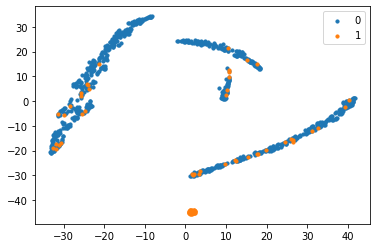

In [29]:
fig, ax = plt.subplots()
for g in np.unique(test_label_numpy):
    ix = np.where(test_label_numpy == g)
    ax.scatter(reduction_emb[ix, 0], reduction_emb[ix, 1], label = g, s = 10)
ax.legend()
plt.show()

In [25]:
# 성능 지표 계산
accuracy = accuracy_score(te_labels_list, te_predictions_list)
auc = roc_auc_score(te_labels_list, te_probabilities_list)
f1 = f1_score(te_labels_list, te_predictions_list)
precision = precision_score(te_labels_list,te_predictions_list)
recall = recall_score(te_labels_list, te_predictions_list)

print("test loss:", round(avg_te_loss, 4), ", cos_loss : ", round(avg_te_cos_loss, 4),
      ", classification_loss :",round(avg_te_classi_loss, 4), 
      # ", contrastive_loss : ", round(avg_te_const_loss,4)
     )
print("Accuracy:", round(accuracy,4), ", AUC: ", round(auc,4), ", F1: ", round(f1,4), ", Precision: ", round(precision,4), ", recall: ", round(recall,4))

np.unique(te_labels_list,  return_counts=True)

test loss: 1.0313 , cos_loss :  0.9141 , classification_loss : 0.1172
Accuracy: 0.9614 , AUC:  0.8807 , F1:  0.7156 , Precision:  1.0 , recall:  0.5571


(array([0, 1]), array([734,  70]))

In [26]:
log_path = './logs'
logs = f'model_lr{lr}_classi{classi_lambda}_dim{ninp}_hid{nhid}_layer{nlayer}_epoch{{epoch}}_{{model}}_{{pe}}_{model_time}.txt'
os.makedirs(os.path.join(log_path, date_dir), exist_ok=True)

results = [accuracy, auc, f1, precision, recall]
cm = confusion_matrix(te_labels_list, te_predictions_list)
with open(os.path.join(log_path, date_dir, logs.format(epoch=best_epoch, model=model_name, pe=pe)), 'w') as f:
    f.write(logs.format(epoch=best_epoch, model=model_name, pe=pe))
    f.write('\n')
    f.write(str(results))
    f.write('\n')
    f.write(str(cm))

In [23]:
confusion_matrix(te_labels_list, te_predictions_list)

array([[734,   0],
       [ 31,  39]])